# COVID Prediction Project
### Zequn Li
-----

## 0. Project Architecture

#### Core equation:
##### Existing(t+1) = Existing(t) + NewConfirmed(t) - Death(t) - Cured(t)
#### Specifically:
##### NewConfirmed(t) = NewTested(t) * InfectionRate(t, state demographic distribution, state mobility, ?other information: population density, temperature, Existing, surrounding state existing, ...)
##### Death(t) = Existing(t+dt1) * DeathRate(state demographic)
##### Cured(t) = Existing(t+dt2) * RecoverRate(demographic)

## 1. Exploration Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DeathRate = pd.read_csv("data/COVID-19_Case_Surveillance_Public_Use_Data.csv")
DeathRate.info()

C:\Users\zequn\.conda\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760066 entries, 0 to 5760065
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 483.4+ MB


In [3]:
DeathRate.head(5)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/06/30,NaN,NaN,Probable Case,Other,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
1,2020/06/30,NaN,NaN,Probable Case,Other,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
2,2020/07/05,NaN,NaN,Laboratory-confirmed case,Other,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing
3,2020/06/10,NaN,2020/03/27,Probable Case,Other,0 - 9 Years,Unknown,No,Unknown,No,Unknown
4,2020/07/13,NaN,2020/04/20,Probable Case,Other,0 - 9 Years,Unknown,No,Unknown,No,Unknown


In [4]:
DeathRate["death"] = (DeathRate["death_yn"] == "Yes").astype(float)
DeathRate = DeathRate[["sex", "age_group", "Race and ethnicity (combined)", "death"]]
DeathRate = DeathRate[(DeathRate["sex"].isin(["Male", "Female"]))&
                        (~DeathRate["Race and ethnicity (combined)"].isin(["Unknown", "NA"]))&
                        (~DeathRate["age_group"].isin(["Unknown", "NA"]))]

In [5]:
df_sum_dr = DeathRate.groupby(["sex", "age_group", "Race and ethnicity (combined)"]).agg(["mean", "count"])

In [6]:
df_sum_dr.reset_index(inplace=True)
df_sum_dr

sex    age_group                      Race and ethnicity (combined)  \
                                                                              
0    Female  0 - 9 Years        American Indian/Alaska Native, Non-Hispanic   
1    Female  0 - 9 Years                                Asian, Non-Hispanic   
2    Female  0 - 9 Years                                Black, Non-Hispanic   
3    Female  0 - 9 Years                                    Hispanic/Latino   
4    Female  0 - 9 Years                       Multiple/Other, Non-Hispanic   
..      ...          ...                                                ...   
121    Male    80+ Years                                Black, Non-Hispanic   
122    Male    80+ Years                                    Hispanic/Latino   
123    Male    80+ Years                       Multiple/Other, Non-Hispanic   
124    Male    80+ Years  Native Hawaiian/Other Pacific Islander, Non-Hi...   
125    Male    80+ Years                                White, Non-Hispanic   

        death         
         mean  count  
0    0.000000   1154  
1    0.000000   1544  
2    0.000594  10109  
3    0.000351  22781  
4    0.000337   2966  
..        ...    ...  
121  0.378761   9605  
122  0.391887   7839  
123  0.352417   2917  
124  0.430233     86  
125  0.363906  49969  

[126 rows x 5 columns]

In [7]:
new_columns = ["".join(col) for col in df_sum_dr.columns]
df_sum_dr.columns = new_columns

Text(0, 0.5, 'Confirmed Count')

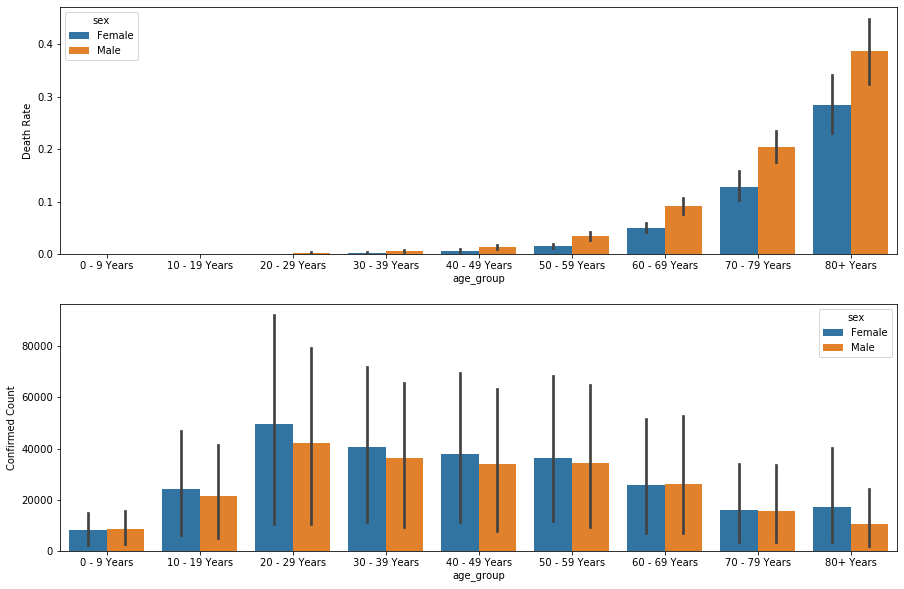

In [172]:
fig, axs = plt.subplots(2,1,figsize=(15,10))
sns.barplot(data=df_sum_dr, x="age_group", y="deathmean", hue="sex", ax=axs[0])
axs[0].set_ylabel('Death Rate')

sns.barplot(data=df_sum_dr, x="age_group", y="deathcount", hue="sex", ax=axs[1])
axs[1].set_ylabel('Confirmed Count')

Text(0, 0.5, 'Confirmed Count')

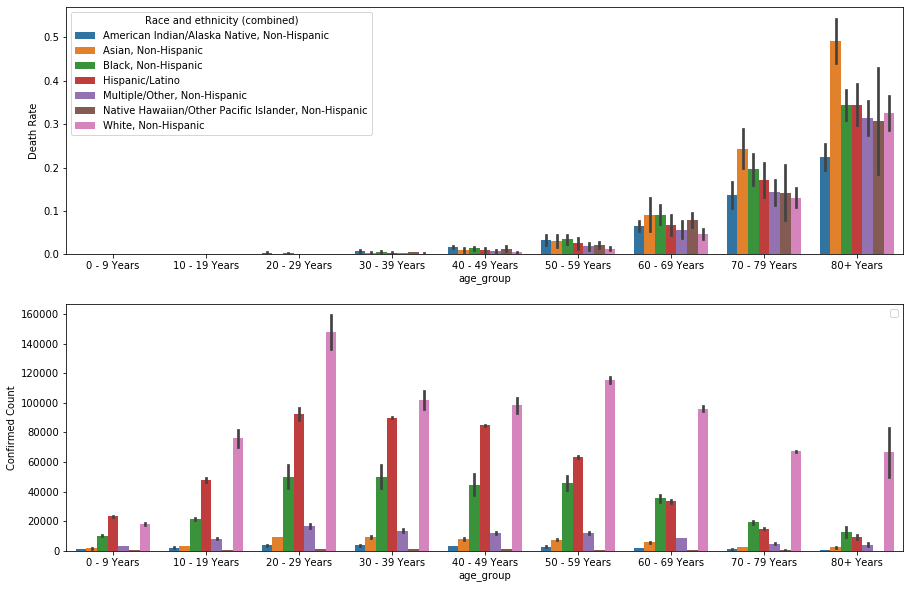

In [171]:
fig, axs = plt.subplots(2,1,figsize=(15,10))
sns.barplot(data=df_sum_dr, x="age_group", y="deathmean", hue="Race and ethnicity (combined)", ax=axs[0])
axs[0].set_ylabel("Death Rate")

sns.barplot(data=df_sum_dr, x="age_group", y="deathcount", hue="Race and ethnicity (combined)", ax=axs[1])
axs[1].legend('')
axs[1].set_ylabel('Confirmed Count')

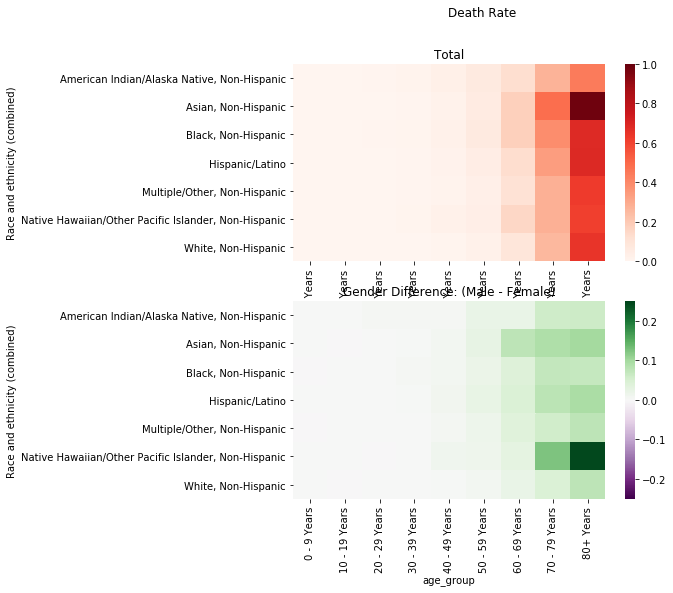

In [93]:
fig, axs = plt.subplots(2,1,figsize=(7,8))
fig.suptitle("Death Rate")
axs[0].set_title("Total")
axs[1].set_title("Gender Difference: (Male - Female)")

df_diff = pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Male"], values='deathmean', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum) - pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Female"], values='deathmean', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum)
sns.heatmap(pd.pivot_table(df_sum_dr, values='deathmean', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum), vmin=0, vmax=1, ax=axs[0], cmap="Reds")
sns.heatmap(df_diff, vmin=-0.25, vmax=0.25, ax=axs[1], cmap="PRGn")

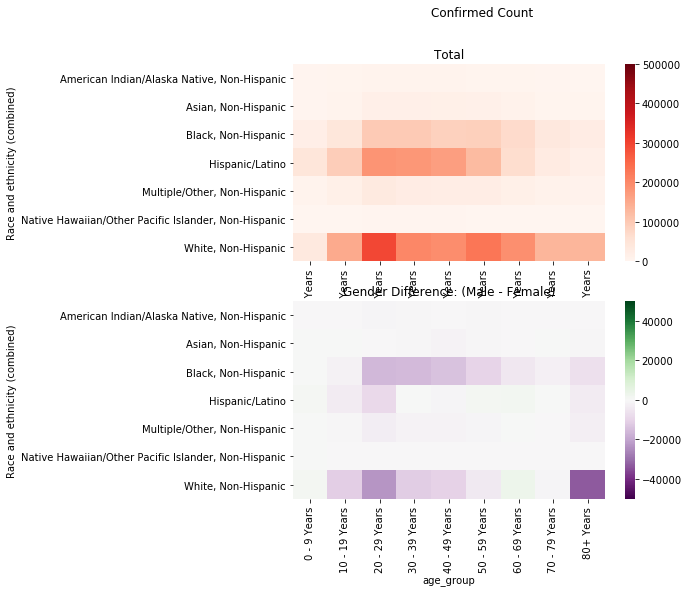

In [94]:
fig, axs = plt.subplots(2,1,figsize=(7,8))

fig.suptitle("Confirmed Count")
axs[0].set_title("Total")
axs[1].set_title("Gender Difference: (Male - Female)")

df_diff = pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Male"], values='deathcount', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum) - pd.pivot_table(df_sum_dr[df_sum_dr.sex=="Female"], values='deathcount', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum)
sns.heatmap(pd.pivot_table(df_sum_dr, values='deathcount', columns=['age_group'], index=['Race and ethnicity (combined)'], aggfunc=np.sum), vmin=0, vmax=5e5, ax=axs[0], cmap="Reds")
sns.heatmap(df_diff, vmin=-5e4, vmax=5e4, ax=axs[1], cmap="PRGn")

In [52]:
dict_race = {1: "White, Non-Hispanic",
             2: "Black, Non-Hispanic",
             3: "American Indian/Alaska Native, Non-Hispanic",
             4: "Asian, Non-Hispanic",
             5: "Native Hawaiian/Other Pacific Islander, Non-Hispanic",
             6: "Multiple/Other, Non-Hispanic"}

def tag_race(row):
    if row.ORIGIN == 2:
        return "Hispanic/Latino"
    else:
        return dict_race[row.RACE]

In [53]:
stateDemo = pd.read_csv("data/sc-est2019-alldata6.csv")

In [54]:
stateDemo.head(5)

,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,ORIGIN,RACE,AGE,CENSUS2010POP,...,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019
0,40,3,6,1,Alabama,0,0,1,0,37991,...,37818,38678,37824,36812,37575,37698,37629,37526,36370,35594
1,40,3,6,1,Alabama,0,0,1,1,38150,...,38036,37719,38597,37854,36968,37882,37732,37904,37641,36679
2,40,3,6,1,Alabama,0,0,1,2,39738,...,39570,38202,37653,38528,37769,37123,38048,37975,38172,37904
3,40,3,6,1,Alabama,0,0,1,3,39827,...,39805,39690,38113,37716,38605,37896,37266,38170,38197,38510
4,40,3,6,1,Alabama,0,0,1,4,39353,...,39493,39872,39628,38122,37751,38625,37954,37322,38312,38476


In [55]:
stateDemo = stateDemo[["NAME", "SEX", "ORIGIN", "RACE", "AGE", "POPESTIMATE2019"]]
stateDemo = stateDemo[(stateDemo.SEX != 0)&
                      (stateDemo.ORIGIN != 0)]
stateDemo["RACE_NEW"] = stateDemo.apply(tag_race, axis=1)
stateDemo["AGE_GROUP"] = [min(8, AGE // 10) for AGE in stateDemo.AGE]
df_sum_stateDemo = stateDemo[["NAME", "SEX", "RACE_NEW", "AGE_GROUP", "POPESTIMATE2019"]].groupby(["NAME", "SEX", "RACE_NEW", "AGE_GROUP"]).sum().reset_index()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

def plot_map(data, title="", cmap=plt.cm.hot, vmin_=None, vmax_=None):
    ATOLL_CUTOFF = 0.005

    m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

    m.readshapefile('d:/state_shape/st99_d00', name='states', drawbounds=True)

    ax = plt.gca()

    colors={}
    statenames=[]
    vmin = np.min(data.values) if not vmin_ else vmin_
    vmax = np.max(data.values) if not vmax_ else vmax_

    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename in data.index:
            num = data.loc[statename,:][0]
            colors[statename] = cmap((num-vmin)/(vmax-vmin))
            statenames.append(statename)

    for i, shapedict in enumerate(m.states_info):
        statename = shapedict['NAME']
        seg = m.states[int(shapedict['SHAPENUM'] - 1)]
        
        if statename in ['Alaska', 'Hawaii']:
            if statename == 'Hawaii' and float(shapedict['AREA']) > ATOLL_CUTOFF:
                seg = list(map(lambda s_: (s_[0] + 5200000, s_[1]-1400000), seg))
            elif statename == 'Alaska':
                seg = list(map(lambda s_: (0.35*s_[0] + 1100000, 0.35*s_[1]-1300000), seg))

        try:
            color = rgb2hex(colors[statename]) 
            poly = Polygon(seg,facecolor=color,edgecolor="k", linewidth=0.5)
            ax.add_patch(poly)
        except:
            pass
        
    fig = plt.gcf()
    im = plt.gci()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(cmap=cmap)
    cb = fig.colorbar(sm, ax=ax, cax=cax, orientation='vertical')
    ax_ = cb.ax.get_yaxis()
    ax_.set_ticks([0,1])
    ax_.set_ticklabels(["%.3f"%vmin, "%.3f"%vmax])
    ax.set_title(title)
    return fig

In [57]:
# Visualize US state demo: sex, race, age_group, pop

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


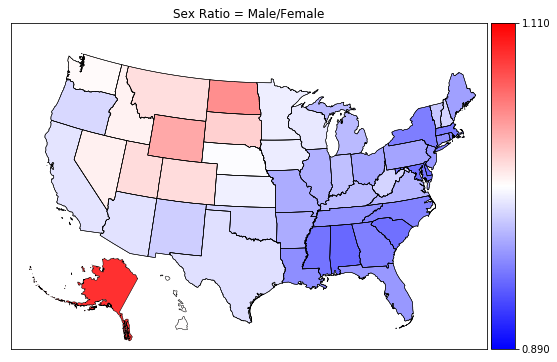

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
data = df_sum_stateDemo[["NAME", "SEX", "POPESTIMATE2019"]].groupby(["NAME", "SEX"]).sum().reset_index()
data = pd.pivot_table(data, index="NAME", columns="SEX", values="POPESTIMATE2019")
data["sex_ratio"] = data[1] / data[2]
ax = plot_map(data[["sex_ratio"]], title="Sex Ratio = Male/Female", cmap=plt.cm.bwr, vmin_=0.89, vmax_=1.11)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


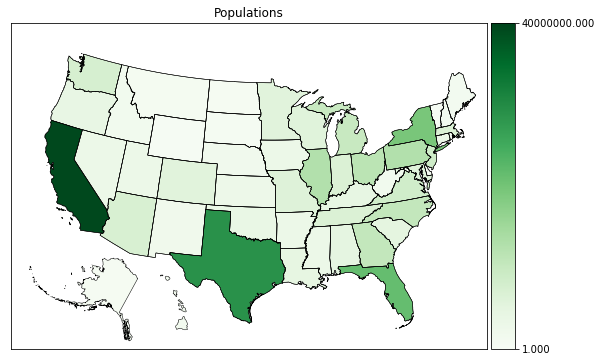

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
data = df_sum_stateDemo[["NAME", "POPESTIMATE2019"]].groupby(["NAME"]).sum()
# plot_map(data["sex_ratio"])
ax = plot_map(data, title="Populations", cmap=plt.cm.Greens, vmin_=1, vmax_=4e7)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


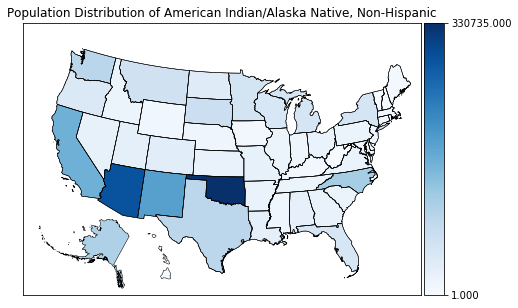

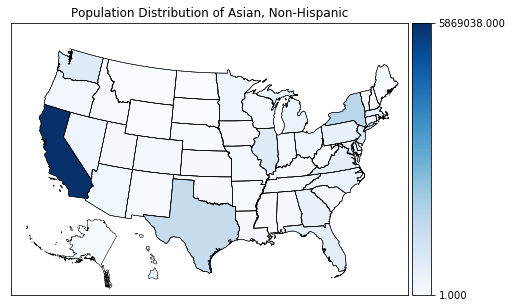

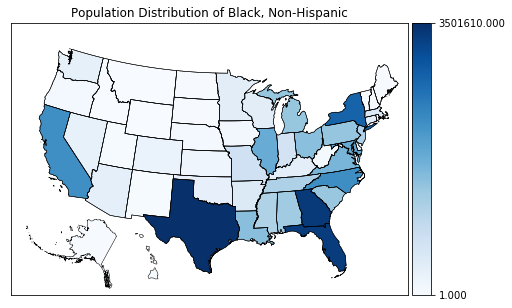

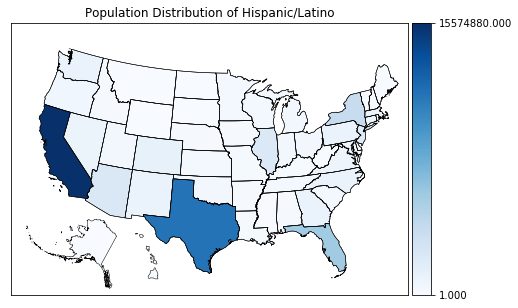

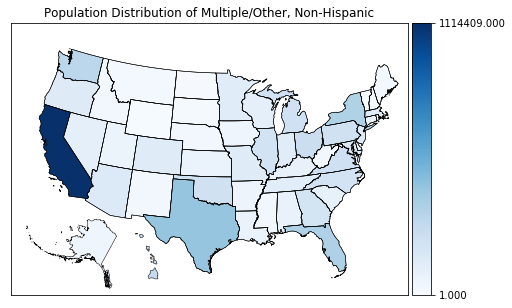

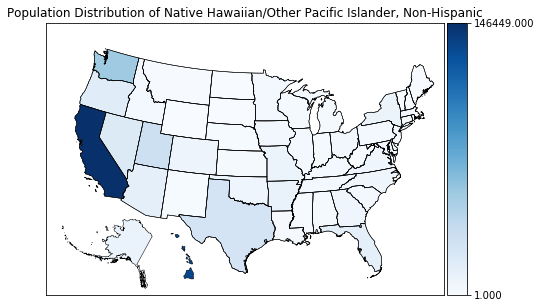

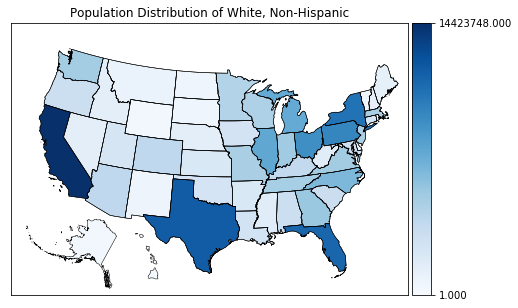

In [60]:
race_list = np.unique(df_sum_stateDemo.RACE_NEW)

for race in race_list:
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    data = df_sum_stateDemo.loc[df_sum_stateDemo.RACE_NEW==race , ["NAME", "POPESTIMATE2019"]].groupby(["NAME"]).sum()
    ax = plot_map(data, title="Population Distribution of "+race, cmap=plt.cm.Blues, vmin_=1, vmax_=None)

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


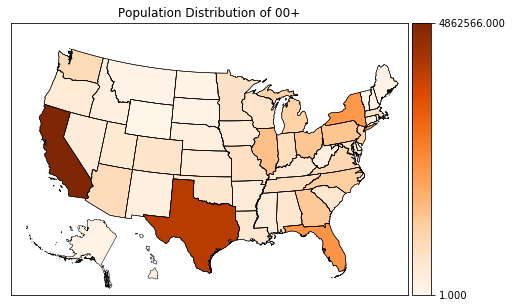

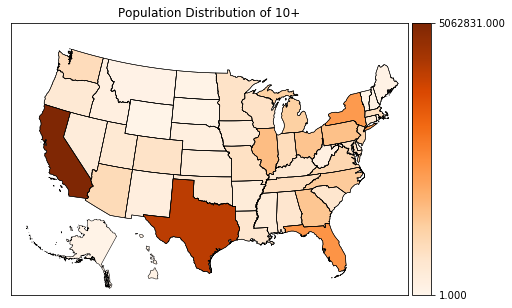

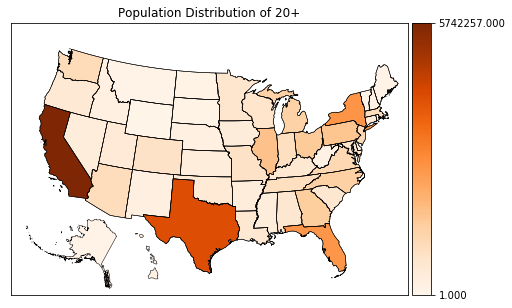

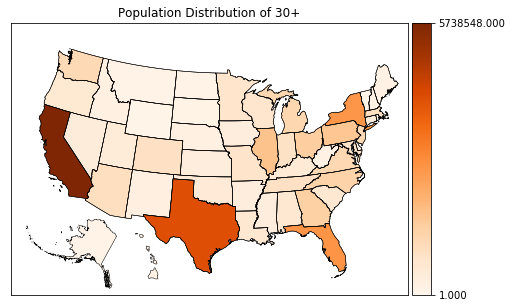

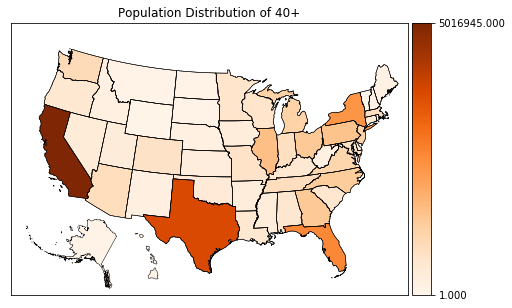

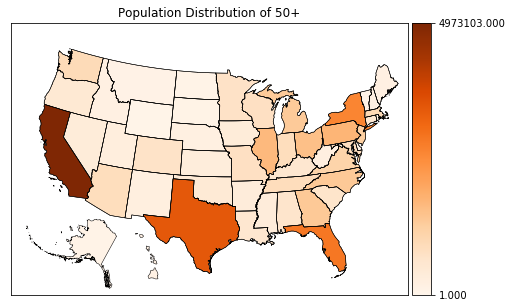

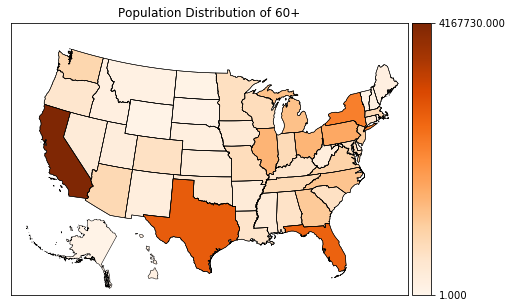

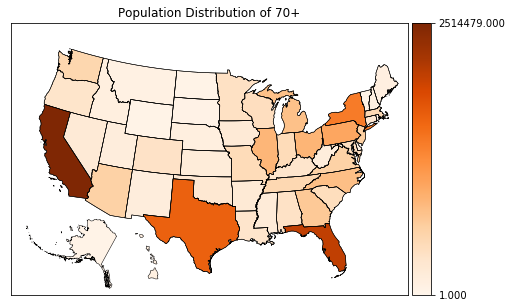

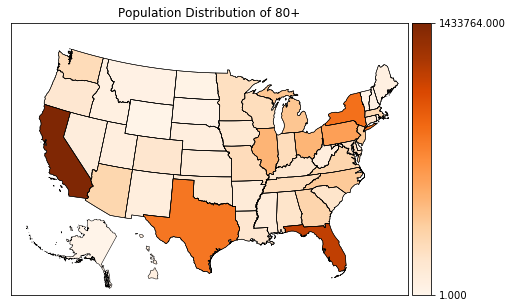

In [63]:
age_list = np.unique(df_sum_stateDemo.AGE_GROUP)

for age in age_list:
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    data = df_sum_stateDemo.loc[df_sum_stateDemo.AGE_GROUP==age , ["NAME", "POPESTIMATE2019"]].groupby(["NAME"]).sum()
    ax = plot_map(data, title="Population Distribution of "+str(age)+"0+", cmap=plt.cm.Oranges, vmin_=1, vmax_=None)

In [64]:
dict_total_pop = {s['NAME']: s['POPESTIMATE2019'] for _, s in df_sum_stateDemo[["NAME", "POPESTIMATE2019"]].groupby("NAME").sum().reset_index().iterrows()}

In [65]:
def tag_sex(s_):
    return 2 if s_ == "Female" else 1
def tag_age(a_):
    return int(a_[0])    

dict_death_rate = {(tag_sex(s["sex"]), s["Race and ethnicity (combined)"], tag_age(s["age_group"])):s["deathmean"] for _, s in df_sum_dr.iterrows()}

In [66]:
df_sum_stateDemo["natural_death_rate"] = df_sum_stateDemo[["SEX", "RACE_NEW", "AGE_GROUP"]].apply(lambda row: dict_death_rate[tuple(row)], axis=1)

In [67]:
df_sum_stateDemo["pop_pct"] = df_sum_stateDemo.apply(lambda row: row['POPESTIMATE2019'] / dict_total_pop[row['NAME']], axis=1)

In [68]:
df_sum_stateDemo["corrected_death_rate"] = df_sum_stateDemo.apply(lambda row: row['natural_death_rate'] * row['pop_pct'], axis=1)
df_state_death = df_sum_stateDemo[["NAME", "corrected_death_rate"]].groupby("NAME").sum()

C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\zequn\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


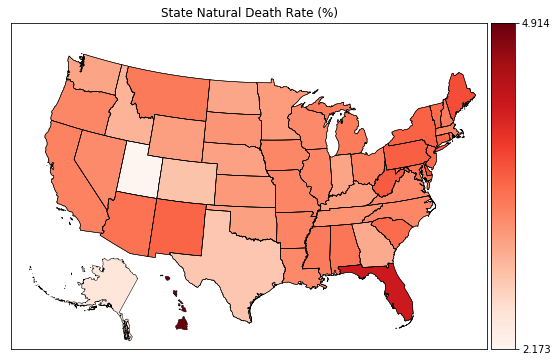

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
data = df_state_death.reset_index().set_index("NAME") * 100
ax = plot_map(data, title="State Natural Death Rate (%)",  cmap=plt.cm.Reds)

In [164]:
import os
import datetime

path = "data/csse_covid_19_daily_reports_us/"
files = os.listdir(path)[:-1]
cols = ["Province_State", "Last_Update", "People_Tested", "Confirmed", "Deaths", "Recovered"]
df_all = pd.DataFrame(columns=cols)
for f in files:
    df_temp = pd.read_csv(path+f)
    df_all = df_all.append(df_temp[cols]).reset_index(drop=True)

df_all = df_all[df_all.Province_State.isin(dict_total_pop.keys())].reset_index(drop=True)
def pct(row, numerator, denominator):
    if row[denominator] == 0.:
        return float(np.nan)
    else:
        return row[numerator] / row[denominator]
    
df_all["Death Percentage"] = df_all.apply(lambda row: 100*pct(row, 'Deaths', 'Confirmed') , axis=1)
df_all["Recover Percentage"] = df_all.apply(lambda row: 100*pct(row, 'Recovered', 'Confirmed') , axis=1)
df_all["Positive Ratio"] = df_all.apply(lambda row: pct(row, 'Confirmed', 'People_Tested'), axis=1)
df_all["Total_pop"] = df_all.apply(lambda row: dict_total_pop[row.Province_State], axis=1)
df_all["Testing Ratio"] = df_all.apply(lambda row: pct(row, 'People_Tested', 'Total_pop'), axis=1)

df_all["Last_Update"] = pd.to_datetime(df_all["Last_Update"]).dt.date
df_all.head(5)

,Province_State,Last_Update,People_Tested,Confirmed,Deaths,Recovered,Death Percentage,Recover Percentage,Positive Ratio,Total_pop,Testing Ratio
0,Alabama,2020-04-12,21583.0,3563,93,NaN,2.610160,NaN,0.165084,4903185,0.004402
1,Alaska,2020-04-12,8038.0,272,8,66.0,2.941176,24.264706,0.033839,731545,0.010988
2,Arizona,2020-04-12,42109.0,3542,115,NaN,3.246753,NaN,0.084115,7278717,0.005785
3,Arkansas,2020-04-12,19722.0,1280,27,367.0,2.109375,28.671875,0.064902,3017804,0.006535
4,California,2020-04-12,190328.0,22795,640,NaN,2.807633,NaN,0.119767,39512223,0.004817


In [165]:
df_lastday = df_all.iloc[-51:, :]
top_n = 10
cols = ["People_Tested", "Confirmed", "Deaths", "Recovered", "Death Percentage", "Recover Percentage", "Positive Ratio", "Testing Ratio"]
for col in cols:
    print("Top " + str(top_n) + " "+col+" States")
    print("--------------------------------------------")
    print(df_lastday[["Province_State", col]].sort_values(by=col, ascending=False, na_position='last').head(top_n))
    print("============================================")

Top 10 People_Tested States
--------------------------------------------
       Province_State  People_Tested
10612      California     19396349.0
10640        New York     15355881.0
10617         Florida     10405346.0
10651           Texas      8553766.0
10621        Illinois      8215129.0
10629   Massachusetts      6547668.0
10630        Michigan      5207467.0
10638      New Jersey      4863436.0
10643            Ohio      4700814.0
10641  North Carolina      4277376.0
Top 10 Confirmed States
--------------------------------------------
       Province_State Confirmed
10651           Texas    977222
10612      California    963211
10617         Florida    832625
10640        New York    522021
10621        Illinois    465540
10618         Georgia    370106
10641  North Carolina    288569
10650       Tennessee    273144
10657       Wisconsin    256065
10610         Arizona    254764
Top 10 Deaths States
--------------------------------------------
      Province_State Deaths
10640

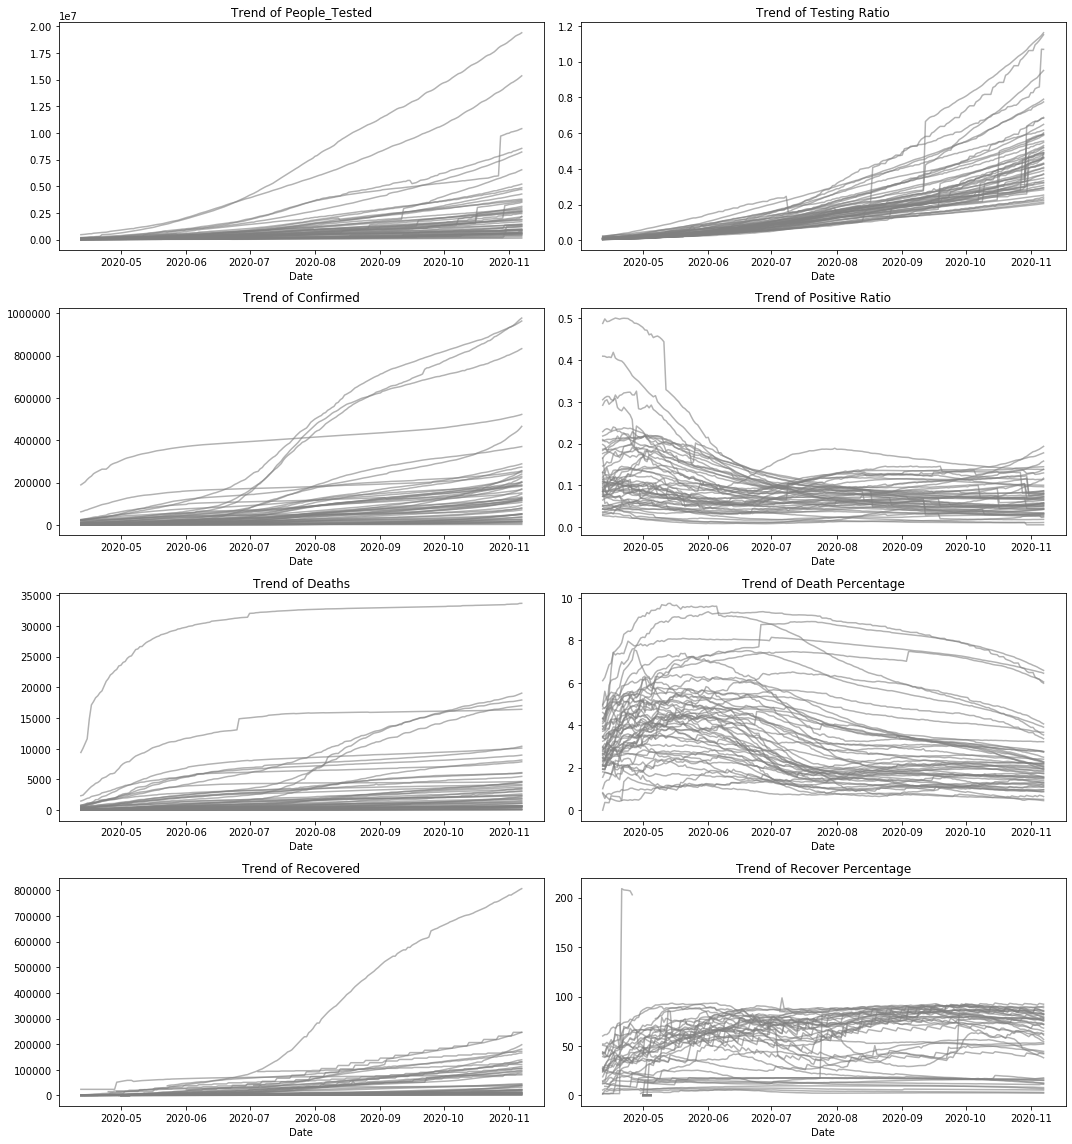

In [167]:
fig, axs = plt.subplots(4,2,figsize=(15,16), tight_layout=True)

left_list = ["People_Tested", "Confirmed", "Deaths", "Recovered"]
right_list = ["Testing Ratio", "Positive Ratio", "Death Percentage", "Recover Percentage"]

for i, (left, right) in enumerate(zip(left_list, right_list)):
    
    for label, df in df_all[["Province_State", "Last_Update", left]].groupby("Province_State"):
        df.set_index("Last_Update", inplace=True)
        (df[left]).plot(ax=axs[i][0], label=label, alpha=0.6, color="gray")
    axs[i][0].set_title("Trend of "+ left)
    axs[i][0].set_xlabel("Date")
    
    for label, df in df_all[["Province_State", "Last_Update", right]].groupby("Province_State"):
        df.set_index("Last_Update", inplace=True)
        (df[right]).plot(ax=axs[i][1], label=label, alpha=0.6, color="gray")
    axs[i][1].set_title("Trend of " + right)
    axs[i][1].set_xlabel("Date")
    

### Hospital data: updated daily, but archive data not available

In [54]:
hospital = pd.read_csv("data/State_Representative_Estimates_for_Hospital_Utilization.csv")
hospital.head(5)

,OBJECTID,state_name,total_inpatient_beds,total_icu_beds,pct_inpatient_bed_utilization,pct_inpatients_with_covid,pct_icu_bed_utilization,icu_beds_used_estimate,inpatient_beds_used_estimate,inpatient_beds_used_covid_est,last_updated
0,1,Alaska,1178.0,228.0,62.51,7.29,75.40,95.0,892.0,104.0,2020/11/06 14:45:00+00
1,2,California,60674.0,8744.0,71.60,5.60,70.22,5073.0,44587.0,3490.0,2020/11/06 14:45:00+00
2,3,Hawaii,1745.0,299.0,68.56,3.29,69.96,170.0,1700.0,81.0,2020/11/06 14:45:00+00
3,4,Idaho,3604.0,513.0,54.96,8.82,75.59,223.0,1932.0,310.0,2020/11/06 14:45:00+00
4,5,Nevada,7311.0,1152.0,75.31,10.37,75.09,642.0,5500.0,738.0,2020/11/06 14:45:00+00


In [55]:
mobility = pd.read_csv("data/Trips_by_Distance.csv")
mobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117622 entries, 0 to 2117621
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Level                           object 
 1   Date                            object 
 2   State FIPS                      float64
 3   State Postal Code               object 
 4   County FIPS                     float64
 5   County Name                     object 
 6   Population Staying at Home      object 
 7   Population Not Staying at Home  object 
 8   Number of Trips                 object 
 9   Number of Trips <1              object 
 10  Number of Trips 1-3             object 
 11  Number of Trips 3-5             object 
 12  Number of Trips 5-10            object 
 13  Number of Trips 10-25           object 
 14  Number of Trips 25-50           object 
 15  Number of Trips 50-100          object 
 16  Number of Trips 100-250         object 
 17  Number of Trips 250-500    

In [56]:
mobility.head(5)

,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,County,2019/01/01,29.0,MO,29171.0,Putnam County,"1,155","3,587","12,429","2,807","3,642","1,272","1,240","1,953","1,058",283,101,54,19
1,County,2019/01/01,2.0,AK,2164.0,Lake and Peninsula Borough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,County,2019/01/01,1.0,AL,1001.0,Autauga County,"9,624","45,807","132,004","27,097","35,263","18,315","18,633","22,963","5,149","2,575","1,592",322,95
3,County,2019/01/01,1.0,AL,1003.0,Baldwin County,"44,415","172,941","534,520","120,752","142,931","68,235","87,430","78,045","24,495","7,079","3,188","1,693",672
4,County,2019/01/01,1.0,AL,1005.0,Barbour County,"4,782","20,023","67,658","15,524","16,677","10,550","11,674","6,416","3,686","2,450",589,66,26


### Temperature data: station-wise daily average temperature for 2017. [Downloaded]

### Marginal death rate: https://www.ssa.gov/oact/STATS/table4c6.html or https://www.cdc.gov/nchs/data/dvs/MortFinal2007_Worktable23f.pdf
### Bayes rule: P(Death|Covid) * P(Covid) = P(Death, Covid) = P(Covid|Death) * P(Death)
### Add demographic data somewhere
#### => P(Covid|Death) = P(Death|Covid) * P(Covid) / P(Death)
##### - P(Death|Covid): Estimated as in the death rate table above
##### - P(Covid): Estimated as in test positive probability as above
##### - P(Death): Lookup from the link in this block